In [1]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/NamO/NamO1.csv"
df = pd.read_csv(file_path)
df.head()

Mounted at /content/drive


,0,-0.00081276,-2.2076e-05,-0.00048974,-0.0010116,-0.00033622,-0.00084749,-0.0018109,-0.00089151,-0.0010941,...,0.00071401,-0.00021137,-0.0010275,2.7127e-05.1,-0.00048771,-0.00030422.1,-1.6267e-05,-0.0019425,-0.00043957.1,0.1
0,0,-0.000942,0.000267,-0.000527,-0.001279,-0.000258,-0.001076,-0.002193,-0.000713,-0.000991,...,0.000711,-0.000337,-0.001448,-0.000282,-0.000722,-0.000206,-0.000004,-0.002585,-0.000611,0
1,0,-0.000814,0.000686,-0.000408,-0.001281,-0.000049,-0.001123,-0.002103,-0.000181,-0.000503,...,0.000482,-0.000395,-0.001630,-0.000683,-0.000854,0.000061,0.000022,-0.002766,-0.000674,0
2,0,-0.000417,0.001253,-0.000121,-0.001020,0.000309,-0.000969,-0.001554,0.000703,0.000347,...,0.000060,-0.000377,-0.001549,-0.001156,-0.000880,0.000494,0.000093,-0.002465,-0.000612,0
3,0,0.000020,0.001747,0.000180,-0.000682,0.000645,-0.000758,-0.000906,0.001536,0.001165,...,-0.000354,-0.000315,-0.001347,-0.001540,-0.000835,0.000910,0.000163,-0.001985,-0.000498,0
4,0,0.000331,0.001911,0.000362,-0.000386,0.000806,-0.000536,-0.000366,0.001951,0.001592,...,-0.000596,-0.000226,-0.001029,-0.001648,-0.000722,0.001102,0.000199,-0.001407,-0.000368,0


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader

torch.manual_seed(42)

In [4]:
# Xử lý dữ liệu bị thiếu
df.fillna(method='ffill', inplace=True)

# Chọn một cảm biến để dự báo (ví dụ: cột thứ 2)
data = df.iloc[:, 1].values.reshape(-1, 1)

<ipython-input-4-bd5f48c86a75>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [5]:
# Hàm thêm dữ liệu bị mất
def introduce_missing_data(data, missing_percentage):
    data_missing = data.copy()
    num_missing = int(len(data) * missing_percentage / 100)
    missing_indices = np.random.choice(len(data), num_missing, replace=False)
    data_missing[missing_indices] = np.nan
    return data_missing, missing_indices



In [6]:
# Hàm tạo chuỗi thời gian theo cửa sổ trượt
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [7]:
from sklearn.model_selection import train_test_split

def split_dataset(X, y, train_ratio=0.8):
    return train_test_split(X, y, test_size=1-train_ratio, shuffle=False)


In [10]:
# Xây dựng mô hình LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_size=1, hidden_size=50, num_layers=2, output_size=1)

In [13]:
# Chọn tỷ lệ dữ liệu bị mất
missing_percentages = [10, 20, 30]
results = {}

for missing_percentage in missing_percentages:
    print(f"\n*** Xử lý với {missing_percentage}% dữ liệu bị mất ***")

    # Tạo dữ liệu bị mất
    data_missing, missing_indices = introduce_missing_data(data, missing_percentage)

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data_missing)

    # Điền dữ liệu bị thiếu bằng nội suy
    df_filled = pd.DataFrame(data_scaled).interpolate(limit_direction='both').values

    # Điều chỉnh độ dài chuỗi
    if missing_percentage == 30:
        seq_length = 10
    elif missing_percentage == 20:
        seq_length = 20
    else:
        seq_length = 50

    # Tạo tập dữ liệu
    X, y = create_sequences(df_filled, seq_length)

    # Kiểm tra dữ liệu có đủ không
    if X.shape[0] == 0:
        print("Không đủ dữ liệu để huấn luyện. Bỏ qua trường hợp này!")
        continue

    # Chia tập train/test
    X_train, X_test, y_train, y_test = split_dataset(X, y)

    # Huấn luyện mô hình
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        X_train = X_train.view(X_train.shape[0], seq_length, -1)
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    # Dự đoán
    X_test = X_test.view(X_test.shape[0], seq_length, -1)
    y_pred = model(X_test).detach().numpy()
    y_pred = scaler.inverse_transform(y_pred)

    # Điền giá trị dự đoán vào dữ liệu gốc
    data_filled_final = data_missing.copy()
    for idx, missing_idx in enumerate(missing_indices[:len(y_pred)]):
        data_filled_final[missing_idx] = y_pred[idx]

    results[missing_percentage] = data_filled_final
    print(f"Dữ liệu bị mất ({missing_percentage}%) đã được dự đoán hoàn tất!")


*** Xử lý với 10% dữ liệu bị mất ***
Không đủ dữ liệu để huấn luyện. Bỏ qua trường hợp này!

*** Xử lý với 20% dữ liệu bị mất ***
Epoch 0, Loss: 0.7181192636489868
Epoch 5, Loss: 0.5669471025466919
Epoch 10, Loss: 0.4079126715660095
Epoch 15, Loss: 0.20421485602855682
Dữ liệu bị mất (20%) đã được dự đoán hoàn tất!

*** Xử lý với 30% dữ liệu bị mất ***
Epoch 0, Loss: 0.10094491392374039
Epoch 5, Loss: 0.15684334933757782
Epoch 10, Loss: 0.09709716588258743
Epoch 15, Loss: 0.10213245451450348
Dữ liệu bị mất (30%) đã được dự đoán hoàn tất!


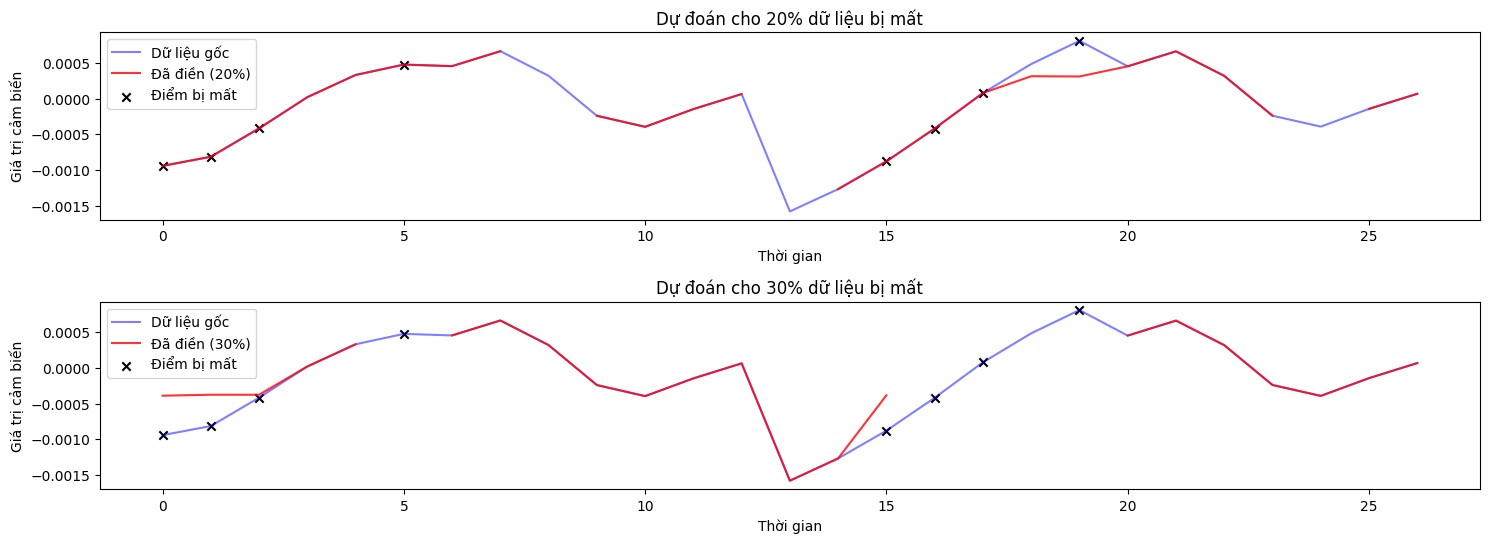

In [15]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cho từng mức mất dữ liệu
plt.figure(figsize=(15, 8))

for i, missing_percentage in enumerate(missing_percentages):
    if missing_percentage not in results:
        continue  # Bỏ qua nếu không có dữ liệu hợp lệ

    data_filled_final = results[missing_percentage]

    plt.subplot(3, 1, i + 1)
    plt.plot(data, label="Dữ liệu gốc", color='blue', alpha=0.5)
    plt.plot(data_filled_final, label=f"Đã điền ({missing_percentage}%)", color='red', alpha=0.8)

    # Đánh dấu các điểm bị mất ban đầu
    plt.scatter(missing_indices, data[missing_indices], color='black', marker='x', label="Điểm bị mất")

    plt.title(f"Dự đoán cho {missing_percentage}% dữ liệu bị mất")
    plt.legend()
    plt.xlabel("Thời gian")
    plt.ylabel("Giá trị cảm biến")

plt.tight_layout()
plt.show()